In [1]:
import sys, re, numpy, random, string,json,pyLDAvis,operator
from nltk.corpus import reuters
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/vshebuniayeu/anaconda3/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


In [31]:
iteration=50
samplesize = 200

In [32]:
#случайной выборкой забираем определенное количество тем
idlist = random.sample(reuters.fileids(), samplesize)

In [33]:
labels = []
corpus = []
for id in idlist:
    labels.append(reuters.categories(id))
    corpus.append([x.lower() for x in reuters.words(id) if x[0] in string.ascii_letters])
    reuters.words(id).close()
labelset = list(set(reduce(list.__add__, labels)))

In [34]:
labelset

['iron-steel',
 'lead',
 'soybean',
 'dmk',
 'oilseed',
 'wheat',
 'corn',
 'alum',
 'bop',
 'ship',
 'gold',
 'dlr',
 'barley',
 'wpi',
 'cpi',
 'earn',
 'money-fx',
 'livestock',
 'copper',
 'heat',
 'pet-chem',
 'palm-oil',
 'housing',
 'coffee',
 'rubber',
 'nat-gas',
 'yen',
 'money-supply',
 'sugar',
 'carcass',
 'grain',
 'gas',
 'trade',
 'acq',
 'hog',
 'veg-oil',
 'cotton',
 'rape-oil',
 'rice',
 'lumber',
 'reserves',
 'interest',
 'silver',
 'fuel',
 'zinc',
 'meal-feed',
 'ipi',
 'cocoa',
 'orange',
 'crude']

In [35]:
alpha=0.001
beta=0.001

In [36]:
class LLDA:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    def set_corpus(self, labelset, corpus, labels):
        labelset.insert(0, "common")
        self.labelmap = dict(zip(labelset, range(len(labelset))))        
        self.K = len(self.labelmap)
        self.vocas = []
        self.vocas_id = dict()
        self.labels = numpy.array([self.complement_label(label) for label in labels])

        
        self.docs = [[self.term_to_id(term) for term in doc] for doc in corpus]        
        M = len(corpus)
        V = len(self.vocas)

        self.z_m_n = []
        self.n_m_z = numpy.zeros((M, self.K), dtype=int)
        self.n_z_t = numpy.zeros((self.K, V), dtype=int)
        self.n_z = numpy.zeros(self.K, dtype=int)        
        for m, doc, label in zip(range(M), self.docs, self.labels):
            N_m = len(doc)
            #z_n = [label[x] for x in numpy.random.randint(len(label), size=N_m)]
            z_n = [numpy.random.multinomial(1, label / label.sum()).argmax() for x in range(N_m)]
            self.z_m_n.append(z_n)
            for t, z in zip(doc, z_n):
                self.n_m_z[m, z] += 1
                self.n_z_t[z, t] += 1
                self.n_z[z] += 1        
    def complement_label(self, label):
        if not label: return numpy.ones(len(self.labelmap))
        vec = numpy.zeros(len(self.labelmap))
        vec[0] = 1.0
        for x in label:            
            vec[self.labelmap[x]] = 1.0
        return vec
    def term_to_id(self, term):
        if term not in self.vocas_id:
            voca_id = len(self.vocas)
            self.vocas_id[term] = voca_id
            self.vocas.append(term)
        else:
            voca_id = self.vocas_id[term]
        return voca_id
    def perplexity(self, docs=None):
        if docs == None: docs = self.docs
        phi = self.phi()
        thetas = self.theta()

        log_per = N = 0
        for doc, theta in zip(docs, thetas):
            for w in doc:
                log_per -= numpy.log(numpy.inner(phi[:,w], theta))
            N += len(doc)
        return numpy.exp(log_per / N)
    def phi(self):
        V = len(self.vocas)        
        return (self.n_z_t + self.beta) / (self.n_z[:, numpy.newaxis] + V * self.beta)

    def theta(self):
        """document-topic distribution"""
        n_alpha = self.n_m_z + self.labels * self.alpha
        return n_alpha / n_alpha.sum(axis=1)[:, numpy.newaxis]
    def inference(self):
        V = len(self.vocas)
        for m, doc, label in zip(range(len(self.docs)), self.docs, self.labels):
            for n in range(len(doc)):
                t = doc[n]
                z = self.z_m_n[m][n]
                self.n_m_z[m, z] -= 1
                self.n_z_t[z, t] -= 1
                self.n_z[z] -= 1

                denom_a = self.n_m_z[m].sum() + self.K * self.alpha
                denom_b = self.n_z_t.sum(axis=1) + V * self.beta
                p_z = label * (self.n_z_t[:, t] + self.beta) / denom_b * (self.n_m_z[m] + self.alpha) / denom_a
                new_z = numpy.random.multinomial(1, p_z / p_z.sum()).argmax()

                self.z_m_n[m][n] = new_z
                self.n_m_z[m, new_z] += 1
                self.n_z_t[new_z, t] += 1
                self.n_z[new_z] += 1

In [37]:
llda = LLDA(alpha, beta)

In [38]:
llda.set_corpus(labelset, corpus, labels)

In [39]:
labelmap = dict(zip(labelset, range(len(labelset))))            
K = len(labelmap)
print("M=%d, V=%d, L=%d, K=%d" % (len(corpus), len(llda.vocas), len(labelset), K))

M=200, V=4231, L=51, K=51


In [40]:
x = []
y = []
for i in range(iteration):
    perplexity = llda.perplexity()
    sys.stderr.write("-- %d : %.4f\n" % (i, perplexity))
    x.append(i)
    y.append(perplexity)
    llda.inference()
print("perplexity : %.4f" % llda.perplexity())

-- 0 : 358.5390
-- 1 : 321.6760
-- 2 : 316.9259
-- 3 : 316.7135
-- 4 : 317.2810
-- 5 : 317.5040
-- 6 : 317.7242
-- 7 : 318.5550
-- 8 : 317.7261
-- 9 : 317.5380
-- 10 : 317.9215
-- 11 : 318.0364
-- 12 : 318.2874
-- 13 : 318.4820
-- 14 : 319.0819
-- 15 : 319.7073
-- 16 : 320.0978
-- 17 : 320.4806
-- 18 : 319.7905
-- 19 : 319.9505
-- 20 : 319.3358
-- 21 : 319.0682
-- 22 : 319.8359
-- 23 : 319.1033
-- 24 : 319.8474
-- 25 : 318.0307
-- 26 : 319.1041
-- 27 : 318.5455
-- 28 : 318.1671
-- 29 : 318.7230
-- 30 : 318.4272
-- 31 : 318.0681
-- 32 : 319.1669
-- 33 : 317.7490
-- 34 : 317.6658
-- 35 : 317.8837
-- 36 : 318.2097
-- 37 : 317.5104
-- 38 : 317.5428
-- 39 : 317.5162
-- 40 : 316.7347
-- 41 : 317.2145
-- 42 : 316.6266
-- 43 : 315.8806
-- 44 : 316.7741
-- 45 : 317.3834
-- 46 : 317.9135
-- 47 : 317.8827
-- 48 : 316.4876
-- 49 : 317.2454


perplexity : 316.2532


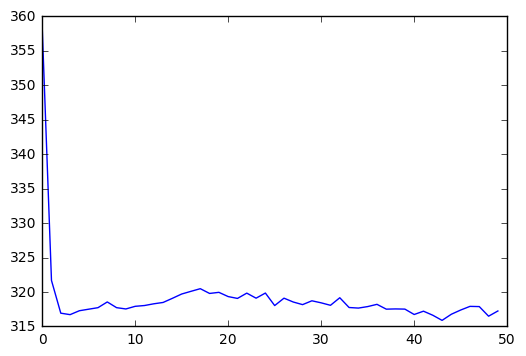

In [42]:

plt.plot(x, y)

In [43]:
phi = llda.phi()
result = {}
for k, label in enumerate(labelset):
    #print("\n-- label %d : %s" % (k, label))
    result[label]=[]
    for w in numpy.argsort(-phi[k])[:10]:
        #print("%s: %.4f" % (llda.vocas[w], phi[k,w]))
        result[label].append(str(llda.vocas[w])+":"+str(phi[k,w]))

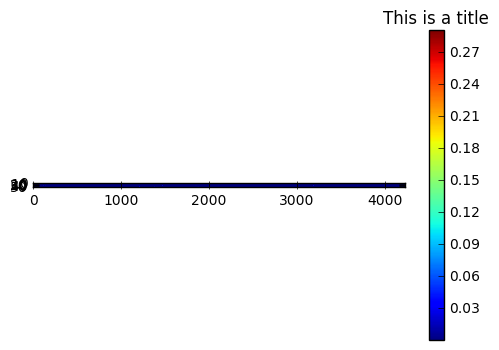

In [60]:
import numpy as np
import matplotlib.pylab as plt 

#dat = np.random.randn(10,10)
dat = phi
#dat = np.array(dat)
#dat = np.minimum(100, dat*100)
#dat = dat.astype(np.int32)


plt.imshow(dat, interpolation='none')

clb = plt.colorbar()
clb.ax.set_title('This is a title')

#plt.show()

In [61]:
dat

array([[  5.75863344e-08,   5.75863344e-08,   1.15230255e-04, ...,
          1.15230255e-04,   5.75863344e-08,   5.75863344e-08],
       [  5.73950675e-06,   5.73950675e-06,   5.73950675e-06, ...,
          5.73950675e-06,   5.73950675e-06,   5.73950675e-06],
       [  5.19993760e-05,   5.19993760e-05,   5.19993760e-05, ...,
          5.19993760e-05,   5.19993760e-05,   5.19993760e-05],
       ..., 
       [  3.81228318e-05,   3.81228318e-05,   3.81228318e-05, ...,
          3.81228318e-05,   3.81228318e-05,   3.81228318e-05],
       [  1.38444712e-05,   1.38444712e-05,   1.38444712e-05, ...,
          1.38444712e-05,   1.38444712e-05,   1.38444712e-05],
       [  1.38268409e-06,   1.38268409e-06,   1.38268409e-06, ...,
          1.38268409e-06,   1.38268409e-06,   1.38268409e-06]])

In [256]:
pandaResult = pd.DataFrame(result).T

In [257]:
pandaResult

,0,1,2,3,4,5,6,7,8,9
acq,lt:0.0387761605233,it:0.0213768243825,and:0.0208797004928,for:0.0198854527133,shares:0.0193883288236,inc:0.0169027093749,its:0.0164055854852,corp:0.0159084615954,merger:0.012925718257,mln:0.012925718257
alum,azpurua:0.0634549703397,credit:0.0634549703397,financing:0.0423068382485,state:0.0423068382485,obtained:0.0423068382485,credits:0.0423068382485,mln:0.0423068382485,marks:0.0317327722029,venezuela:0.0317327722029,reached:0.0211587061573
barley,tonnes:0.158213205197,maize:0.0791164896878,traders:0.0593423108105,french:0.0593423108105,series:0.0395681319333,licences:0.0395681319333,mln:0.0395681319333,weekly:0.0395681319333,rejects:0.0395681319333,ago:0.0395681319333
bop,billion:0.118840142514,in:0.0959867084427,the:0.0914160216285,dlrs:0.0845599914071,quarter:0.0502798403002,of:0.0457091534859,deficit:0.0411384666717,third:0.0274264062289,s:0.0251410628218,foreign:0.0228557194147
carcass,agriculture:0.0318624523178,chicken:0.0318624523178,bird:0.0318624523178,usda:0.0318624523178,pork:0.0318624523178,foreman:0.0238988301439,former:0.0238988301439,every:0.0238988301439,inspection:0.0238988301439,poultry:0.0238988301439
cocoa,buffer:0.0716346185152,stock:0.0716346185152,cocoa:0.0520996802782,icco:0.0455880341992,delegates:0.0390763881202,compromise:0.0260530959621,producer:0.0260530959621,member:0.0195414498831,different:0.0195414498831,how:0.0195414498831
coffee,producers:0.0696589144047,coffee:0.0626937194837,ico:0.0557285245628,producer:0.0348329397998,meeting:0.0348329397998,organization:0.0278677448788,consumers:0.0278677448788,delegates:0.0278677448788,quotas:0.0278677448788,session:0.0278677448788
common,the:0.0719718894653,of:0.0462899741159,to:0.0450410055883,a:0.0352834389661,said:0.0334880467077,in:0.0298972621907,and:0.0266187198057,s:0.0182662427772,for:0.0138167923975,on:0.0124897633369
copper,outokumpu:0.1029626732,del:0.0617858392868,copper:0.0617858392868,iberica:0.0617858392868,cobre:0.0617858392868,spanish:0.0617858392868,billion:0.0411974223302,markka:0.0206090053736,turnover:0.0206090053736,finland:0.0206090053736
corn,exports:0.168910866934,stocks:0.103226956677,end:0.0844601251748,start:0.0750767094238,balance:0.0656932936728,not:0.0656932936728,years:0.0563098779218,differing:0.0563098779218,world:0.0469264621708,reporting:0.0375430464198


In [258]:
tf = {}
for doc in llda.docs:
    for w in doc:
        if w in tf:
            tf[w]+=1
        else:
            tf[w]=1
            
tf2 = {}
for e in llda.vocas_id:
    tf2[e]=tf[llda.vocas_id[e]]
    
data = {'topic_term_dists': llda.phi(),
        'doc_topic_dists': llda.theta(),
        'vocab':llda.vocas,
        'doc_lengths':doc_lengths,
        'term_frequency':tf2
       }

#term_frequency

In [259]:
movies_model_data = data

In [260]:
print('Topic-Term shape: %s' % str(np.array(movies_model_data['topic_term_dists']).shape))
print('Doc-Topic shape: %s' % str(np.array(movies_model_data['doc_topic_dists']).shape))

Topic-Term shape: (46, 3571)
Doc-Topic shape: (200, 46)


In [261]:
movies_vis_data = pyLDAvis.prepare(**movies_model_data)

In [262]:
pyLDAvis.display(movies_vis_data)

In [265]:
sorted_x = sorted(llda.labelmap.items(), key=operator.itemgetter(1))
pd.Series(sorted_x)

0            (common, 0)
1             (trade, 1)
2            (barley, 2)
3           (veg-oil, 3)
4          (money-fx, 4)
5              (ship, 5)
6             (grain, 6)
7           (nat-gas, 7)
8          (palm-oil, 8)
9           (soybean, 9)
10            (jobs, 10)
11        (soy-meal, 11)
12            (corn, 12)
13            (rice, 13)
14         (oilseed, 14)
15             (dmk, 15)
16             (acq, 16)
17             (yen, 17)
18             (cpi, 18)
19            (alum, 19)
20          (rubber, 20)
21          (coffee, 21)
22            (gold, 22)
23             (dlr, 23)
24       (meal-feed, 24)
25          (copper, 25)
26           (sugar, 26)
27       (livestock, 27)
28             (gnp, 28)
29            (earn, 29)
30    (money-supply, 30)
31            (zinc, 31)
32        (rapeseed, 32)
33             (ipi, 33)
34         (soy-oil, 34)
35         (carcass, 35)
36       (groundnut, 36)
37        (pet-chem, 37)
38        (reserves, 38)
39             (bop, 39)


In [266]:
sorted_x = sorted(llda.labelmap.items(), key=operator.itemgetter(1))

In [267]:
sorted_x

[('common', 0),
 ('trade', 1),
 ('barley', 2),
 ('veg-oil', 3),
 ('money-fx', 4),
 ('ship', 5),
 ('grain', 6),
 ('nat-gas', 7),
 ('palm-oil', 8),
 ('soybean', 9),
 ('jobs', 10),
 ('soy-meal', 11),
 ('corn', 12),
 ('rice', 13),
 ('oilseed', 14),
 ('dmk', 15),
 ('acq', 16),
 ('yen', 17),
 ('cpi', 18),
 ('alum', 19),
 ('rubber', 20),
 ('coffee', 21),
 ('gold', 22),
 ('dlr', 23),
 ('meal-feed', 24),
 ('copper', 25),
 ('sugar', 26),
 ('livestock', 27),
 ('gnp', 28),
 ('earn', 29),
 ('money-supply', 30),
 ('zinc', 31),
 ('rapeseed', 32),
 ('ipi', 33),
 ('soy-oil', 34),
 ('carcass', 35),
 ('groundnut', 36),
 ('pet-chem', 37),
 ('reserves', 38),
 ('bop', 39),
 ('heat', 40),
 ('wheat', 41),
 ('interest', 42),
 ('cotton', 43),
 ('cocoa', 44),
 ('crude', 45)]

In [268]:
llda.K

46

In [272]:
doc_lengths = []
for e in llda.docs:
    doc_lengths.append(len(e))
    
data = {'topic_term_dists': llda.phi(),
        'doc_topic_dists': llda.theta(),
        'vocab':llda.vocas,
        'doc_lengths':doc_lengths,
        'term_frequency':tf2
       }

In [273]:
len(corpus)

200

In [112]:
set_corpus(self, labelset, corpus, labels):
        labelset.insert(0, "common")
        self.labelmap = dict(zip(labelset, range(len(labelset))))        
        self.K = len(self.labelmap)
        self.vocas = []
        self.vocas_id = dict()
        

        
        self.docs = [[self.term_to_id(term) for term in doc] for doc in corpus]
        print(self.docs)
        M = len(corpus)
        V = len(self.vocas)

        self.z_m_n = []
        self.n_m_z = numpy.zeros((M, self.K), dtype=int)
        self.n_z_t = numpy.zeros((self.K, V), dtype=int)
        self.n_z = numpy.zeros(self.K, dtype=int)
        print(self.n_m_z)
        print(self.n_z_t)
        print(self.n_z)
        for m, doc, label in zip(range(M), self.docs, self.labels):
            N_m = len(doc)
            #z_n = [label[x] for x in numpy.random.randint(len(label), size=N_m)]
            z_n = [numpy.random.multinomial(1, label / label.sum()).argmax() for x in range(N_m)]
            self.z_m_n.append(z_n)
            for t, z in zip(doc, z_n):
                self.n_m_z[m, z] += 1
                self.n_z_t[z, t] += 1
                self.n_z[z] += 1        
    def perplexity(self, docs=None):
        if docs == None: docs = self.docs
        phi = self.phi()
        thetas = self.theta()

        log_per = N = 0
        for doc, theta in zip(docs, thetas):
            for w in doc:
                log_per -= numpy.log(numpy.inner(phi[:,w], theta))
            N += len(doc)
        return numpy.exp(log_per / N)
    def phi(self):
        
        return (self.n_z_t + self.beta) / (self.n_z[:, numpy.newaxis] + V * self.beta)

    def inference(self):
        
        for m, doc, label in zip(range(len(self.docs)), self.docs, self.labels):
            for n in range(len(doc)):
                t = doc[n]
                z = self.z_m_n[m][n]
                self.n_m_z[m, z] -= 1
                self.n_z_t[z, t] -= 1
                self.n_z[z] -= 1

                denom_a = self.n_m_z[m].sum() + self.K * self.alpha
                denom_b = self.n_z_t.sum(axis=1) + V * self.beta
                p_z = label * (self.n_z_t[:, t] + self.beta) / denom_b * (self.n_m_z[m] + self.alpha) / denom_a
                new_z = numpy.random.multinomial(1, p_z / p_z.sum()).argmax()

                
                

SyntaxError: invalid syntax (<ipython-input-112-1728ee9abfeb>, line 1)

In [140]:
for k,v in (llda.vocas_id).items():
    if v == 67:
        print(k)    

session


In [274]:
len(llda.vocas_id)

3571

In [275]:
len(llda.docs)

200

In [146]:
tf

{0: 5,
 1: 66,
 2: 156,
 3: 1,
 4: 20,
 5: 675,
 6: 9,
 7: 13,
 8: 17,
 9: 14,
 10: 485,
 11: 239,
 12: 5,
 13: 505,
 14: 3,
 15: 20,
 16: 12,
 17: 678,
 18: 158,
 19: 3,
 20: 10,
 21: 2,
 22: 2,
 23: 5,
 24: 2,
 25: 1,
 26: 466,
 27: 6,
 28: 161,
 29: 71,
 30: 1248,
 31: 196,
 32: 251,
 33: 26,
 34: 79,
 35: 7,
 36: 22,
 37: 6,
 38: 2,
 39: 15,
 40: 1,
 41: 22,
 42: 621,
 43: 4,
 44: 269,
 45: 25,
 46: 2,
 47: 53,
 48: 4,
 49: 137,
 50: 230,
 51: 2,
 52: 13,
 53: 31,
 54: 106,
 55: 16,
 56: 13,
 57: 36,
 58: 7,
 59: 398,
 60: 15,
 61: 4,
 62: 85,
 63: 4,
 64: 3,
 65: 130,
 66: 9,
 67: 6,
 68: 74,
 69: 3,
 70: 9,
 71: 2,
 72: 7,
 73: 14,
 74: 55,
 75: 39,
 76: 9,
 77: 57,
 78: 196,
 79: 12,
 80: 25,
 81: 2,
 82: 5,
 83: 2,
 84: 1,
 85: 5,
 86: 43,
 87: 135,
 88: 229,
 89: 8,
 90: 13,
 91: 5,
 92: 25,
 93: 3,
 94: 19,
 95: 14,
 96: 8,
 97: 134,
 98: 1,
 99: 44,
 100: 18,
 101: 12,
 102: 37,
 103: 6,
 104: 31,
 105: 1,
 106: 1,
 107: 2,
 108: 5,
 109: 2,
 110: 44,
 111: 149,
 112: 79,
 1

In [148]:
llda.vocas_id

{'funds': 122,
 'adherence': 1761,
 'thinking': 745,
 'ven': 943,
 'adviser': 291,
 'business': 306,
 'television': 1196,
 'overall': 687,
 'rbi': 3109,
 'leys': 1947,
 'anglo': 1654,
 'siemens': 2588,
 'petrolane': 2947,
 'target': 392,
 'bill': 2136,
 'operating': 647,
 'commerzbank': 3187,
 'termed': 786,
 'fulfill': 600,
 'implemented': 1775,
 'executive': 859,
 'term': 151,
 'nsm': 3494,
 'contends': 1702,
 'influence': 303,
 'sweeping': 510,
 'ten': 2824,
 'hoping': 3518,
 'currencies': 1554,
 'discontinued': 1453,
 'maintain': 1166,
 'chemical': 1139,
 'remained': 390,
 'foresaw': 2537,
 'underlying': 3072,
 'forming': 2096,
 'du': 626,
 'guatemalan': 1299,
 'intended': 866,
 'h': 2064,
 'despite': 896,
 'congressmen': 3147,
 'see': 3003,
 'wash': 1261,
 'yangtze': 2306,
 'opposition': 3376,
 'lpg': 2948,
 'england': 63,
 'importer': 2835,
 'rebuilt': 1809,
 'diw': 1381,
 'itt': 1208,
 'indicate': 2778,
 'attempted': 2338,
 'credit': 2817,
 'sets': 343,
 'beatrice': 3560,
 'twel

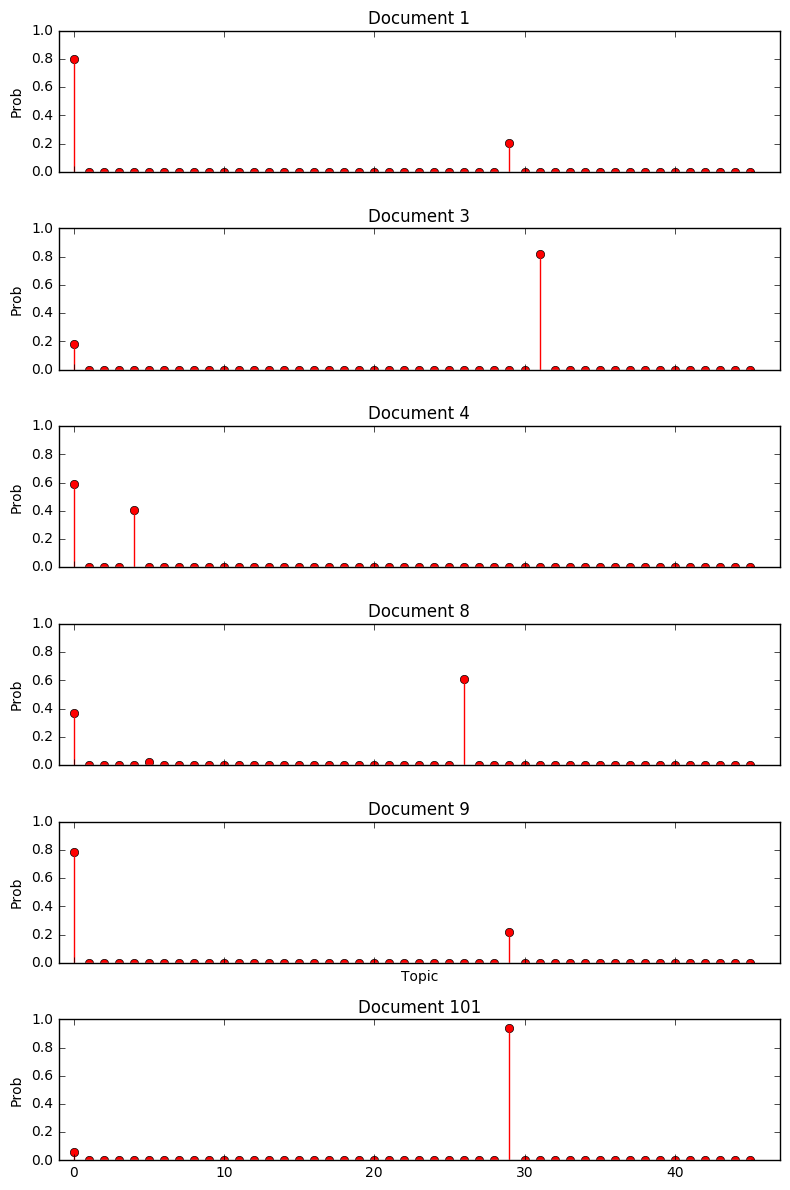

In [276]:
f, ax= plt.subplots(6, 1, figsize=(8, 12), sharex=True)
K = len(labelmap)
for i, k in enumerate([1, 3, 4, 8, 9,101]):
    #ax[i].stem(doc_topic[k,:], linefmt='r-',
    ax[i].stem(llda.theta()[k], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-1, K+1)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("Document {}".format(k))    
    
ax[4].set_xlabel("Topic")
plt.tight_layout()
#текст документа
#название тематики

In [283]:
print(corpus[101])
#print(llda.theta()[100])
print(llda.theta()[101][29])
print(sorted_x[29])
print(sorted_x[13])

['academy', 'insurance', 'group', 'inc', 'lt', 'acig', 'qtr', 'net', 'shr', 'profit', 'two', 'cts', 'vs', 'loss', 'dlrs', 'net', 'profit', 'vs', 'loss', 'revs', 'mln', 'vs', 'mln', 'avg', 'shrs', 'mln', 'vs', 'mln', 'year', 'shr', 'loss', 'cts', 'vs', 'loss', 'dlrs', 'net', 'loss', 'vs', 'loss', 'revs', 'mln', 'vs', 'mln', 'avg', 'shrs', 'mln', 'vs', 'mln', 'note', 'results', 'include', 'losses', 'of', 'nil', 'vs', 'dlrs', 'or', 'three', 'cts', 'a', 'share', 'in', 'quarter', 'and', 'dlrss', 'or', 'three', 'cts', 'a', 'share', 'vs', 'dlrs', 'or', 'seven', 'cts', 'a', 'share', 'in', 'year', 'from', 'discontinued', 'operations']
0.93795620438
('earn', 29)
('rice', 13)


In [238]:
#print(corpus[100])
print(corpus[9])
#print(llda.theta()[100])
print(llda.theta()[9][:13])
print(sorted_x[12])
print(sorted_x[13])

['indonesian', 'soybean', 'imports', 'forecast', 'to', 'rise', 'soybean', 'imports', 'are', 'forecast', 'to', 'rise', 'to', 'tonnes', 'in', 'october', 'september', 'from', 'an', 'estimated', 'in', 'and', 'in', 'the', 'u', 's', 'embassy', 'said', 'in', 'its', 'annual', 'report', 'on', 'indonesia', 's', 'agriculture', 'it', 'said', 'indonesia', 'did', 'not', 'achieve', 'its', 'goal', 'of', 'self', 'sufficiency', 'in', 'soybean', 'output', 'in', 'calendar', 'because', 'it', 'did', 'not', 'meet', 'a', 'planned', 'increase', 'in', 'area', 'planted', 'and', 'because', 'yields', 'have', 'remained', 'below', 'target', 'soybean', 'meal', 'imports', 'are', 'forecast', 'to', 'fall', 'to', 'around', 'tonnes', 'in', 'from', 'tonnes', 'in', 'and', 'tonnes', 'in', 'domestic', 'soybean', 'production', 'is', 'forecast', 'to', 'rise', 'steadily', 'to', 'mln', 'tonnes', 'in', 'from', 'in', 'the', 'current', 'year', 'and', 'in', 'the', 'report', 'said', 'imports', 'are', 'forecast', 'to', 'fall', 'in', 't

In [228]:
print(llda.theta()[101,32])
print(llda.theta()[101,0])

0.999474237645
0.000525762355415


In [187]:
r = (llda.theta())

In [191]:
r[9]

array([ 0.66813551,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.04742952,  0.20379057,  0.        ,  0.        ,
        0.        ,  0.01900024,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.06164416,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [199]:
#self.labelmap = dict(zip(labelset, range(len(labelset))))        

('common', 0)

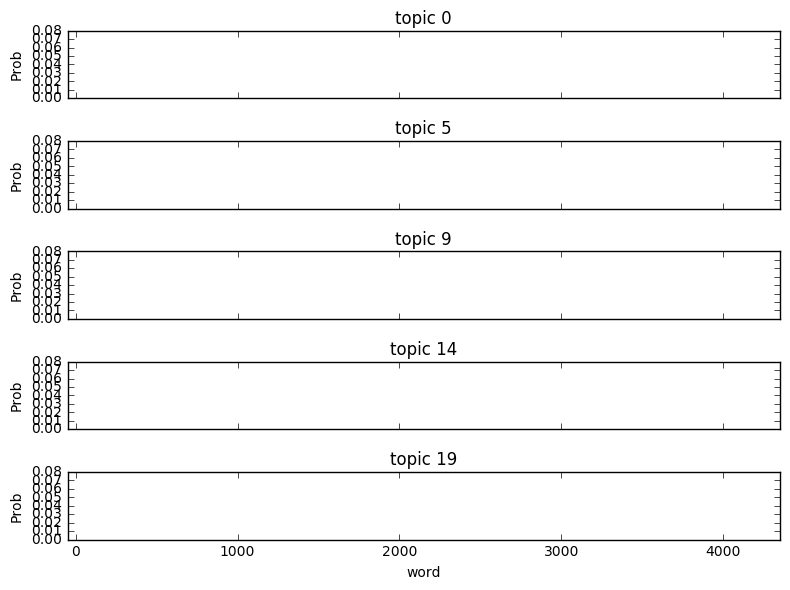

In [264]:
f, ax= plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for i, k in enumerate([0, 5, 9, 14, 19]):
    #ax[i].stem(topic_word[k,:], linefmt='b-',
    #           markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(-50,4350)
    ax[i].set_ylim(0, 0.08)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k))

ax[4].set_xlabel("word")

plt.tight_layout()
plt.show()